In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
from tbparse import SummaryReader
import torch
os.chdir('../')
print(os.getcwd())

/Users/gbemidebe/Documents/GitHub/knnGuidedDesign


In [3]:
#from src.data.loader import load_auto_hp_params
from src.viz.plotters import Parallel_Coordinates

In [4]:
!pwd

/Users/gbemidebe/Documents/GitHub/knnGuidedDesign


In [6]:
log_dir = "reports/VAE/hyper_search_logs/knnMoleculeVAE/version_1/"
reader = SummaryReader(log_dir, pivot=True)
df = reader.scalars
df

,step,epoch,hp_metric,train_loss_epoch,train_loss_step,val_loss_epoch,val_loss_step
0,0,NaN,-1.0,NaN,NaN,NaN,4810.323242
1,1,NaN,NaN,NaN,NaN,NaN,4816.222168
2,2,NaN,NaN,NaN,NaN,NaN,4803.702637
3,3,NaN,NaN,NaN,NaN,NaN,4820.192383
4,4,NaN,NaN,NaN,NaN,NaN,4811.124023
...,...,...,...,...,...,...,...
7299,30149,298.0,NaN,NaN,113.584976,NaN,NaN
7300,30198,"[298.0, 298.0]",NaN,141.438446,NaN,115.004044,NaN
7301,30199,299.0,NaN,NaN,102.613419,NaN,NaN
7302,30249,299.0,NaN,NaN,128.253662,NaN,NaN


In [7]:
len(df)

7304

model.save_hyperparameters({"enc_hidden_dim_1": enc_hidden_dim_1,
                                "dec_hidden_dim_1": dec_hidden_dim_1,
                                "enc_hidden_dim_2": enc_hidden_dim_2,
                                "dec_hidden_dim_2": dec_hidden_dim_2,
                                "learning_rate": learning_rate,
                                "dropout": dropout, "num_epochs": num_epochs,
                                "seed": seed, "batch_size": batch_size,
                                "input_dim": input_dim_train, "latent_dim": latent_dim,
                                "height_dim": height_train, "width_dim": width_train,
                                "split_ratio": split, "max_len": largest_selfies_len})

In [8]:
# params = ['enc_hidden_dim_1', 'enc_hidden_dim_2', 'dec_hidden_dim_1', 'dec_hidden_dim_2',
#              'learning_rate', 'dropout', 'num_epochs', 'seed', 'batch_size', 'input_dim',
#                'latent_dim', 'split_ratio',  'max_len', 
#                'trn_loss', 'val_loss']
params = [r'enc_hidden_dim_1', 'enc_hidden_dim_2', 'dec_hidden_dim_1', 'dec_hidden_dim_2',
             'learning_rate', 'dropout', 'num_epochs', 'seed', 'batch_size',
               'trn_loss', 'val_loss']

ignore_list = ['input_dim', 'max_len', 'latent_dim', 'width_dim', 'height_dim', 'split_ratio']

In [9]:
import yaml
from glob import glob
import pandas as pd
import numpy as np

def load_auto_hp_params(path,
                        params = ['batch_size', 'dec_hidden_dim_1', 'dec_hidden_dim_2',
                         'dropout', 'enc_hidden_dim_1', 'enc_hidden_dim_2', 'height_dim',
                            'input_dim', 'latent_dim', 'learning_rate', 'max_len',
                                  'num_epochs', 'seed', 'split_ratio', 'width_dim', 
                                  'trn_loss', 'val_loss'],
                        ignore_list = ['input_dim', 'latent_dim', 'split_ratio']):

    log_dirs = sorted(glob(path))
    hp_params = {'run': []}
    for pms in params:
        hp_params[pms] = []

    for i,v in enumerate(log_dirs):
        #print(f"Processing {v}")
        reader = SummaryReader(log_dirs[i])
        df = reader.scalars
        #print(f"Length of df is {len(df.keys())}")

        if len(df) > 2:
            hp_params["run"].append(f"run_{i}")
            with open(f"{log_dirs[i]}/hparams.yaml", "r") as file:
                hparams = yaml.safe_load(file)

            for k,v in hparams.items():
                if k not in ignore_list:
                    hp_params[k].append(v)

            train_loss = df[df.tag=="train_loss_epoch"].value.to_numpy()
            val_loss = df[df.tag=="val_loss_epoch"].value.to_numpy()

            hp_params["trn_loss"].append(np.nanmin(train_loss))
            hp_params["val_loss"].append(np.nanmin(val_loss))
        
        #print(f'len of keys is {len(hp_params.keys())}')
        #print([f"{key}: {len(val)}" for key, val in hp_params.items()])
    
    df = pd.DataFrame(hp_params)

    return df

In [10]:
hpp_df = load_auto_hp_params(path="reports/VAE/hyper_search_logs/knnMoleculeVAE/version_*",
                             params=params, ignore_list=ignore_list) # reports/VAE/hyper_search_logs/knnMoleculeVAE/version_*

In [11]:
# hpp_df.columns = [r'\rm run$', r'$\rm enc_hidden_dim_1$', r'$\rm enc_hidden_dim_2', 
#                       r'$\rm dec_hidden_dim_1', r'$\rm dec_hidden_dim_2',
#                         r'$\rm lr$', r'$\rm dropout$', r'$\rm num_epochs$', 
#                         r'$\rm seed$', r'$\rm batch_size$',
#                         r'$\rm trn_loss$', r'$\rm val_loss$']

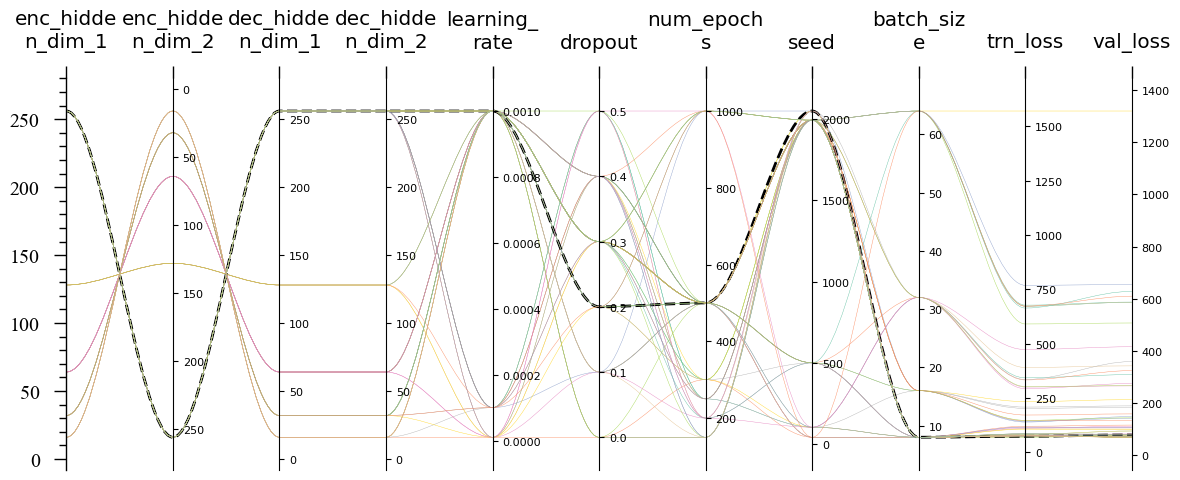

In [12]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(12,5))
pcd = Parallel_Coordinates(df=hpp_df, best_itr=50,ax=ax).plot()
plt.tight_layout()
# plt.savefig("images/hyperparams.png", dpi=200, facecolor='w', edgecolor='none',bbox_inches='tight')
# plt.show()